In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re
import pandas as pd
import scipy.optimize as opt

In [7]:
#讀取台灣50指的資料
index50 = pd.read_csv('台灣50指數資料.csv', encoding='utf-16', sep='\t')

In [8]:
#計算市值與權重並新增欄位
index50['市值'] = index50['公眾流通係數'] * index50['前日調整收盤價']*index50['股數']
index50['成份股'] = index50['成份股'].str.split(' ').str[0]
index50['年月日'] = index50['年月日'].astype(str)
index50

,證券代碼,年月日,成份股,指數因子,公眾流通係數,股數,前日調整收盤價,前日市值比重,市值
0,TWN50 台灣50指數,20190102,1101,0.0021,0.8700,5108059911,35.60,1.0261,1.582068e+11
1,TWN50 台灣50指數,20190102,1102,0.0011,0.6900,3361447198,33.95,0.5107,7.874358e+10
2,TWN50 台灣50指數,20190102,1216,0.0023,0.8500,5682015421,69.80,2.1865,3.371140e+11
3,TWN50 台灣50指數,20190102,1301,0.0023,0.7700,6365740781,101.00,3.2110,4.950637e+11
4,TWN50 台灣50指數,20190102,1303,0.0027,0.7200,7930821589,75.50,2.7962,4.311195e+11
...,...,...,...,...,...,...,...,...,...
48896,TWN50 台灣50指數,20221230,5880,0.0044,0.7200,14008935446,25.65,1.0845,2.587170e+11
48897,TWN50 台灣50指數,20221230,6415,0.0001,0.6600,381075821,432.50,0.4560,1.087781e+11
48898,TWN50 台灣50指數,20221230,6505,0.0006,0.1500,9525959652,79.70,0.4774,1.138828e+11
48899,TWN50 台灣50指數,20221230,8046,0.0001,0.3249,646165487,231.00,0.2033,4.849595e+10


In [9]:
#取出特定年份的成分股
def get_index50_stocks(index50, year):
    stock = index50[index50['年月日'].str.contains(year)]
    stock = stock['成份股'].tolist()[:50]
    return stock

In [10]:
def convert_format_to_float(s):
    s_without_commas = s.replace(',', '')
    s_as_integer = float(s_without_commas)
    return s_as_integer

#抓指定年度與前一年的股價資料
def get_stock_data_for_year(year, stock_code):
    stock_data = []
    for year in range(year-1, year+1):
        for month in range(1, 13):
            # 构建URL
            date = f"{year}{month:02d}01"  # 以指定年份和月份构建日期
            url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={str(stock_code)}"

            # 发送请求
            response = requests.get(url)
            data = response.json()

            # 解析数据
            if 'data' in data:
                stock_data += data['data']
    if stock_data:
        df = pd.DataFrame(stock_data, columns=['Date', 'Volume', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change', 'Transaction'])
        df['Date'] = df['Date'].str.replace('/', '')
        c = df['Close'] != '--'
        df = df[c]
        df = df.reset_index(drop=True)
        df['Close'] = df['Close'].apply(convert_format_to_float)
        return df

def get_stock_prices(stock_list, year):
    stock_prices_dict = {}
    for stock in stock_list:
        stock_prices_dict[stock] = get_stock_data_for_year(int(year), stock)
    return stock_prices_dict

In [20]:
#將股價換算成日報酬率的函數
def get_stocks_daily_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    min_len = min([len(stocks_daily_returns[stock]) for stock in stocks_daily_returns])
    stocks_daily_returns = {stock: stocks_daily_returns[stock][:min_len] for stock in stocks_daily_returns}
    df = pd.DataFrame(stocks_daily_returns)
    df['Date'] = stocks_prices[list(stocks_prices.keys())[0]]['Date']
    df.set_index('Date', inplace=True)
    return df

In [23]:
#計算股票期間內的總報酬
def get_total_return(stocks_prices):
    stocks_expected_return = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_expected_return[stock] = (stock_daily_price[-1] - stock_daily_price[0]) / stock_daily_price[0]
    return pd.Series(stocks_expected_return)

In [25]:
def get_V(stocks_daily_return):
    V = stocks_daily_return.cov()*len(stocks_daily_return.index)
    return V

In [47]:
def get_opt_weight(stocks_prices, R):
    daily_return = get_stocks_daily_returns(stocks_prices)
    V = get_V(daily_return)
    f = get_total_return(stocks_prices).values

    #定義取得fp及Varp的函數
    def get_fp(h):
        return np.dot(h.T, f)

    def get_Varp(h):
        return np.dot(np.dot(h.T, V.values), h)

    #目標式
    def objective(h):
        return 0.5*get_Varp(h)


    #定義限制式1，h的總和要為1
    def constraint1(h):
        return np.sum(h) - 1

    #定義限制式2，fp要等於我們設定的目標報酬率(即Rf)
    def constraint2(h):
        return get_fp(h) - R

    #設定h的權重要在0~1之間
    bound = tuple((0,1) for _ in range(f.shape[0]))


    #將兩個限制式打包成一個tuple
    conditions = ({'type':'eq', 'fun':constraint1}, 
                {'type':'eq', 'fun':constraint2})

    #隨便給一個求解的起始值(每個都先給0.1)
    init_h = np.full((f.shape[0], 1), 1/f.shape[0]).flatten()

    #求解
    result = opt.minimize(objective, init_h, method='SLSQP', bounds=bound, constraints=conditions)
    opt_h = result.x

    dict_opt_h = {}
    for i in range(len(opt_h)):
        dict_opt_h[list(stocks_prices.keys())[i]] = opt_h[i]

    return dict_opt_h

    

開始!!!!!!!!!!!!GO!!!!

In [233]:
#HW3的程式
import datetime

def get_month(date_intstring):
    date = datetime.datetime.strptime(str(date_intstring).split('\n')[0].strip(), '%Y%m%d')
    return date.month

def convert_to_minguo_date(date_str):
    date_obj = datetime.datetime.strptime(str(date_str), '%Y%m%d')
    minguo_year = date_obj.year - 1911
    minguo_date_str = date_obj.strftime(f"{minguo_year}%m%d")
    return minguo_date_str

def get_stockDailyReturn_by_date(stock, date, stock_price):
    _index = stock_price[stock_price['Date'] == str(convert_to_minguo_date(date))].index
    result_df = stock_price.loc[_index.union(_index-1)]
    result_df = result_df.reset_index(drop=True)
    try:
        daily_return = (float(result_df['Close'].iloc[1]) - float(result_df['Close'].iloc[0])) / float(result_df['Close'].iloc[0])
    except Exception as e:
        print(f'股票:{stock} 在{date}計算日報酬時出現錯誤：' + str(e))
        daily_return = 0
    return daily_return * 100


#算權重
def get_weight(daily_data):
    stock_and_weight = {}
    total_value = daily_data['市值'].sum()
    for i in range(len(daily_data)):
        stock_and_weight[daily_data['成份股'][i]] = daily_data['市值'][i]/total_value
    return stock_and_weight

def get_assets_growth(daily_return):
    assets_growth = []
    for i in range(len(daily_return)):
        if i == 0:
            assets_growth.append(100)
        else:
            assets_growth.append(assets_growth[i-1] * (1 + daily_return[i]/100))
    return assets_growth

def get_period_return(assets_growth):
    return (assets_growth[-1] / assets_growth[0]) - 1

def get_index50_daily_return(start_day, end_day):
    index50_daily_return = pd.read_csv('台灣50指數日報酬.csv', encoding='utf-16', sep='\t')
    c1 = index50_daily_return['年月日'] >= start_day
    c2 = index50_daily_return['年月日'] <= end_day
    index50_daily_return = index50_daily_return[c1 & c2]
    index50_daily_return = index50_daily_return.reset_index(drop=True)
    return list(index50_daily_return['日報酬率 %'])

#追蹤
def tracking(year, index50, stock_price_dict_2y):
    #取得index50的日報酬
    start_date = year + '0102'
    end_date = year + '1231'
    index50_daily_return = get_index50_daily_return(int(start_date), int(end_date))
    # index50_assets_growth = get_assets_growth(index50_daily_return)
    #先找出本年度第一個交易日的index50投資組合權重
    data_of_the_date = {}
    for i in range(0, len(index50)):
        if index50['年月日'][i] not in data_of_the_date:
            data_of_the_date[index50['年月日'][i]] = index50.iloc[i:i+1]
        else:
            data_of_the_date[index50['年月日'][i]] = pd.concat([data_of_the_date[index50['年月日'][i]], index50.iloc[i:i+1]])

    for i in data_of_the_date:
        data_of_the_date[i] = data_of_the_date[i].reset_index(drop=True)
    init_weight = get_weight(data_of_the_date[year+'0102'])

    day_list = list(index50['年月日'])
    day_set = sorted(set(day_list))
    day_set = list([day for day in day_set if int(day) >= int(start_date) and int(day) <= int(end_date)])
    portfolio_daily_return = []
    change = False

    temp_weight_combination = init_weight
    index50_assets_growth = 1
    portfolio_assets_growth = 1
    start = year + '0102'
    
    for idx, day in enumerate(day_set):
        index50_assets_growth *= (1 + index50_daily_return[idx]/100)

        if day not in data_of_the_date:
            continue

        month = get_month(day)
        last_month = month - 1
        weight_combination = init_weight
        stocks = weight_combination.keys()
        if last_month in [3, 6, 9] and get_month(int(day_set[idx-1])) != get_month(int(day)):
            change = True
            end = int(day)
        if change == True and idx != 0:
            index_total_return = (index50_assets_growth - 1)
            portfolio_total_return = (portfolio_assets_growth - 1)
            R_diff = portfolio_total_return - index_total_return
            print(f'指數累積報酬率：{(index50_assets_growth - 1)}')
            print(f'投組累積報酬率：{(portfolio_assets_growth - 1)}')
            print(f'投組與指數報酬率差為：{R_diff}')
            if R_diff < 0.04:
                print(f'投組報酬率增值大於4%，不調整權重，參考區間為：{start} ～　{end}')
                daily_return = 0
                new_weight = {}
                total_weight = 0
                for stock in weight_combination:
                    total_weight += ((get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict_2y[str(stock)])/100 + 1) * temp_weight_combination[stock])
                for stock in weight_combination:
                    new_weight[stock] = ((get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict_2y[str(stock)])/100 + 1) * temp_weight_combination[stock]) / total_weight
                for stock in weight_combination:
                    daily_return += get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict_2y[str(stock)]) * temp_weight_combination[stock]
                temp_weight_combination = new_weight
                
                start = int(day)
                change = False
                portfolio_daily_return.append(daily_return)
            else:  
                print(f'投組權重未增值，需更換權重，參考區間為：{start} ～　{end}')
                excepted_return = 0.05
                stock_price_dict_slice = {}
                for stock in stocks:
                    stock_price_dict_slice[stock] = stock_price_dict_2y[stock][(stock_price_dict_2y[stock]['Date'] >= convert_to_minguo_date(start)) & (stock_price_dict_2y[stock]['Date'] <= convert_to_minguo_date(end))]
                opt_weight = get_opt_weight(stock_price_dict_slice, excepted_return)
                daily_return = 0
                for stock in stocks:
                    daily_return += get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict_2y[str(stock)]) * opt_weight[stock]
                portfolio_daily_return.append(daily_return)
                
                temp_weight_combination = opt_weight
                print(f'權重發生變更：')
                print(temp_weight_combination)
                change = False
                start = int(day)
        else:
            daily_return = 0
            new_weight = {}
            total_weight = 0
            for stock in weight_combination:
                total_weight += ((get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict_2y[str(stock)])/100 + 1) * temp_weight_combination[stock])
            for stock in weight_combination:
                new_weight[stock] = ((get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict_2y[str(stock)])/100 + 1) * temp_weight_combination[stock]) / total_weight
            for stock in weight_combination:
                daily_return += get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict_2y[str(stock)]) * temp_weight_combination[stock]
            temp_weight_combination = new_weight
            portfolio_daily_return.append(daily_return)  
            portfolio_assets_growth *= (1 + daily_return/100)
        print(temp_weight_combination)   

    return portfolio_daily_return
    

In [53]:
year = '2020'
stocks_list = get_index50_stocks(index50, year)
stocks_prices = get_stock_prices(stocks_list, year)

In [234]:
tracking_return = tracking(year, index50, stocks_prices)

{'1101': 0.010496372764695427, '1102': 0.005677096500958618, '2412': 0.0208339215181608, '2454': 0.032671463535500496, '2474': 0.008588404491336372, '2633': 0.0039870519926413295, '2801': 0.007179249262785253, '1216': 0.017937721299813837, '1301': 0.02443661498884533, '1303': 0.02075053652381083, '1326': 0.019296938596134173, '1402': 0.006008438289009283, '2002': 0.014932869737485801, '2105': 0.003893441860058268, '2207': 0.010707532240796822, '2301': 0.0052683739498541856, '2303': 0.009130015210457348, '2308': 0.01649153447566579, '2317': 0.054815586243591, '2327': 0.00866808400664857, '2330': 0.409198062449352, '2357': 0.008194119522482293, '2382': 0.008537956114953544, '2395': 0.005649927369707004, '2408': 0.001984477375889487, '2823': 0.005719598524458503, '2880': 0.010053431646515683, '2881': 0.016893308275958457, '2882': 0.01767021664534345, '2883': 0.00677239793801676, '2884': 0.015443114476500708, '2885': 0.011328130567372207, '2886': 0.016664286898555626, '2887': 0.00737423500

台灣50指數報酬：26.47353274317097%
追蹤50報酬：25.713856061815555%


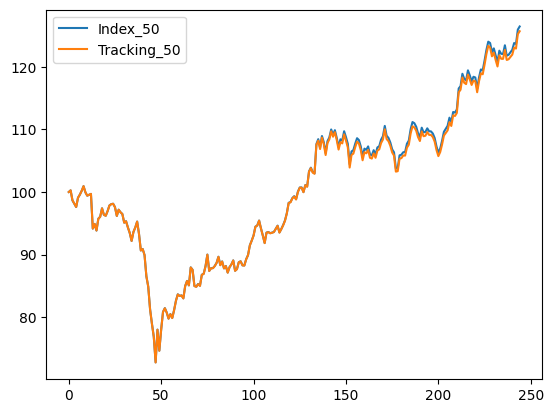

In [241]:
index50_daily_return = pd.read_csv('台灣50指數日報酬.csv', encoding='utf-16', sep='\t')
c1 = index50_daily_return['年月日'] >= int(year + '0102')
c2 = index50_daily_return['年月日'] <= int(year + '1231')
index50_daily_return = index50_daily_return[c1 & c2]
index50_daily_return = index50_daily_return.reset_index(drop=True)
index50_daily_return = list(index50_daily_return['日報酬率 %'])

#畫出台50指成長曲線
import matplotlib.pyplot as plt

print(f'台灣50指數報酬：{(get_assets_growth(list(index50_daily_return))[-1]/get_assets_growth(list(index50_daily_return))[0] - 1)*100}%')
print(f'追蹤50報酬：{(get_assets_growth(tracking_return)[-1]/get_assets_growth(tracking_return)[0] - 1)*100}%')



plt.plot(get_assets_growth(list(index50_daily_return)), label='Index_50')
plt.plot(get_assets_growth(tracking_return), label='Tracking_50')

plt.legend()
plt.show()

In [242]:
def get_tracking_error(tracking_return, index50_daily_return):
    dif = []
    for i in range(len(tracking_return)):
        dif.append(tracking_return[i] - list(index50_daily_return)[i])
    return np.array(dif).std() * np.sqrt(len(tracking_return))

In [243]:
print(f'50 stocks tracking error: {get_tracking_error(tracking_return, index50_daily_return).round(3)}%')

50 stocks tracking error: 0.334%
